In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers.core import Activation, Dense, Dropout
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


## Data Pre-processing

The data from the csv is of an NxD matrix where N represents the number of examples and D is the number of features. This data will need to be normalized and split into windows of size 30 (represents the number of consecutive days) which results in a tensor. The dimensions are then N-w x d x D, where N is the number of examples, w is the window size, d is the number of days to examine in each sampled data, and D is the number of features.

The normalization process is as follows for every feature. For each window, dividing each value by the first value in the window and then, subtract 1. 

After normalizing, the data is split into 90% training data and 10% test data. This is done such that 90% of the windows are used for training data and 10% of the windows are used for testing. We shuffle the windows but not the contents within the window, which ensures that the order of the consecutive days is maintained within the window. 

In [2]:
window_size = 30
file_name = "blockchain_data.csv"
dropout = 0.2
activation_function="linear"
loss_function="mse"
optimizer="adam"
batch_size=1000
nb_epoch=100
validation_split=0.10

raw_dataset = pd.read_csv(file_name)
print("Shape of Data with date: ", raw_dataset.shape)

# Remove date column and change data types to float
dataset = raw_dataset.drop('Date', 1)
print("Shape of data without date: ", dataset.shape)

Shape of Data with date:  (1818, 12)
Shape of data without date:  (1818, 11)


In [3]:
dataset = dataset.values.tolist()
tmp_arr = []
for idx in range(len(dataset) - window_size):
    tmp_arr.append(dataset[idx: idx + window_size])

data = np.array(tmp_arr)
data.shape

(1788, 30, 11)

In [4]:
# Normalize the data
normalized_data = np.zeros_like(data)
normalized_data[:,1:,:] = data[:,1:,:] / data[:, 0:1, :] - 1
print(normalized_data.shape)
normalized_data[-1,:,:]

(1788, 30, 11)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.03526891e-03,  0.00000000e+00, -5.37740978e-02,
         4.42871620e-02,  4.05405405e-02,  1.19726116e-01,
        -1.03708813e-01, -1.34670718e-01, -6.73726840e-02,
        -8.07617418e-02, -8.07617418e-02],
       [-9.86339474e-03,  0.00000000e+00, -1.30137313e-01,
        -6.01418068e-02, -5.40540541e-02, -1.25549454e-01,
         1.36215627e-01,  4.38104636e-02,  7.47985663e-02,
         2.13392749e-01,  2.13392749e-01],
       [-4.10274140e-02,  0.00000000e+00, -2.36333955e-02,
        -4.15726959e-02, -6.75675676e-03, -1.70761313e-01,
         1.63654365e-01,  1.50475409e-01,  1.55791835e-01,
         4.98619751e-01,  4.98619751e-01],
       [-4.33078568e-02,  0.00000000e+00, -1.24267390e-01,
        -7.93547396e-02, -4.05405405e-02, -1.87216289e-01,
  

In [5]:
# Split the data
split_idx = round(0.9*normalized_data.shape[0])
training_data = normalized_data[:int(split_idx), :]
np.random.shuffle(training_data)

X_train = training_data[:, :-1]
Y_train = training_data[:, -1]
Y_train = Y_train[:, 0]
print(X_train.shape)
print(Y_train.shape)

X_test = normalized_data[int(split_idx):, :-1]
Y_test = normalized_data[int(split_idx):, -1, :]
Y_test = Y_test[:, 0]
print(X_test.shape)
print(Y_test.shape)

Y_daybefore = normalized_data[int(split_idx):, -2, :]
Y_daybefore = Y_daybefore[:, 0]
print(Y_daybefore.shape)

# this is because the last window is used as the target
sequence_length = window_size
window_size = window_size - 1

(1609, 29, 11)
(1609,)
(179, 29, 11)
(179,)
(179,)


## Training Step

In [6]:
# create the model
model = Sequential()

# First layer
model.add(Bidirectional(LSTM(window_size, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
model.add(Dropout(dropout))

# Second layer
model.add(Bidirectional(LSTM(window_size*2, return_sequences=True)))
model.add(Dropout(dropout))

# Third layer
model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

# Output Layer
model.add(Dense(units=1))
model.add(Activation(activation_function))

model.compile(loss=loss_function, optimizer=optimizer)

In [7]:
start = time.time()
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=validation_split)
training_time = int(math.floor(time.time() - start))
print("Training time", training_time, "seconds")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1448 samples, validate on 161 samples
Epoch 1/100
1448/1448 [==============================] - 4s 3ms/step - loss: 0.0699 - val_loss: 0.0349
Epoch 2/100
1448/1448 [==============================] - 1s 911us/step - loss: 0.0420 - val_loss: 0.0243
Epoch 3/100
1448/1448 [==============================] - 1s 901us/step - loss: 0.0290 - val_loss: 0.0215
Epoch 4/100
1448/1448 [==============================] - 1s 934us/step - loss: 0.0248 - val_loss: 0.0177
Epoch 5/100
1448/1448 [==============================] - 1s 914us/step - loss: 0.0203 - val_loss: 0.0116
Epoch 6/100
1448/1448 [==============================] - 1s 875us/step - loss: 0.0161 - val_loss: 0.0102
Epoch 7/100
1448/1448 [==============================] - 1s 883us/step - loss: 0.0149 - val_loss: 0.0088
Epoch 8/100
1448/1448 [==============================] - 1s 879us/step - loss: 0.0125 - val_loss: 0.0098
Epoch 9/100
1448/1448 [==============================] - 1s 892us/step - loss: 0.0124 - val_loss: 0.0101
Epoch 10/1

Epoch 79/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 80/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 81/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 82/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 83/100
1448/1448 [==============================] - 3s 2ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 84/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 85/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 86/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 87/100
1448/1448 [==============================] - 2s 1ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 88/100
1448/1448 [==============================] - 2s 2ms

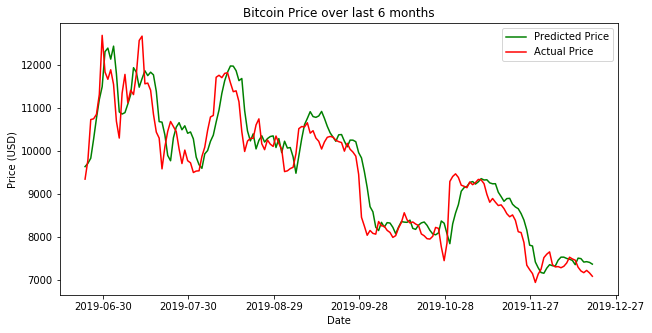

In [8]:
#Test the model
y_predict = model.predict(X_test)

#Create empty 2D arrays to store unnormalized values
real_y_test = np.zeros_like(Y_test)
real_y_predict = np.zeros_like(y_predict)
unnormalized_bases = data[split_idx:,0:1,0]


#Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
for i in range(Y_test.shape[0]):
    y = Y_test[i]
    predict = y_predict[i]
    real_y_test[i] = (y+1)*unnormalized_bases[i]
    real_y_predict[i] = (predict+1)*unnormalized_bases[i]
import matplotlib.dates as mdates

#Plot of the predicted prices versus the real prices
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
now = dt.datetime.now()
then = now - dt.timedelta(days=real_y_predict.shape[0])
days = mdates.drange(then,now,dt.timedelta(days=1))
ax.set_title("Bitcoin Price over last 6 months")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(days, real_y_predict, color = 'green', label = 'Predicted Price')
plt.plot(days, real_y_test, color = 'red', label = 'Actual Price')
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date")
ax.legend()
plt.show()

## Evaluating the Model through Price change

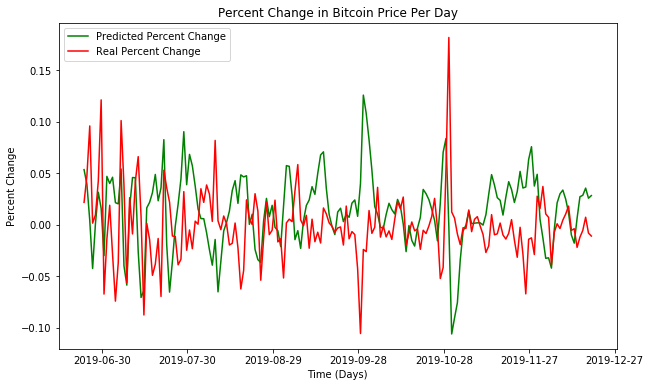

In [9]:
#Reshaping Y_daybefore and Y_test
Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

#The difference between each predicted value and the value from the day before
delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

#The difference between each true value and the value from the day before
delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

#Plotting the predicted percent change versus the real percent change
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Percent Change in Bitcoin Price Per Day")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(days, delta_predict, color='green', label = 'Predicted Percent Change')
plt.plot(days, delta_real, color='red', label = 'Real Percent Change')
plt.ylabel("Percent Change")
plt.xlabel("Time (Days)")
ax.legend()
plt.show()

In [10]:
#Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
delta_predict_1_0 = np.empty(delta_predict.shape)
delta_real_1_0 = np.empty(delta_real.shape)

#If the change in price is greater than zero, store it as a 1
#If the change in price is less than zero, store it as a 0
for i in range(delta_predict.shape[0]):
    if delta_predict[i][0] > 0:
        delta_predict_1_0[i][0] = 1
    else:
        delta_predict_1_0[i][0] = 0
for i in range(delta_real.shape[0]):
    if delta_real[i][0] > 0:
        delta_real_1_0[i][0] = 1
    else:
        delta_real_1_0[i][0] = 0
        
#Finding the number of false positive/negatives and true positives/negatives
true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0
for i in range(delta_real_1_0.shape[0]):
    real = delta_real_1_0[i][0]
    predicted = delta_predict_1_0[i][0]
    if real == 1:
        if predicted == 1:
            true_pos += 1
        else:
            false_neg += 1
    elif real == 0:
        if predicted == 0:
            true_neg += 1
        else:
            false_pos += 1
            
print("True Positives: ", true_pos)
print("True Negatives: ", true_neg)
print("False Positives: ", false_pos)
print("False Negatives: ", false_neg)

accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
print("Accuracy: ", accuracy*100, "%.")

True Positives:  54
True Negatives:  27
False Positives:  73
False Negatives:  25
Accuracy:  45.2513966480447 %.
